# Jurnal Modul 3

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

Script diatas merupakan perintah import untuk meng impor library yang dibutuhkan pada program. Library yang digunakan diantaranya numpy yang berfungsi untuk memudahkan melakukakan perhitungan saintifik seperti matriks, matplotlib yang berfungsi untuk visualisasi data, dan cv2 atau openCV yang berfungsi untuk pemrosesan citra.

Script dibawah ini digunakan untuk membaca dan menampilkan citra yang akan diproses seterusnya oleh program. "plt.imread" adalah fungsi yang digunakan untuk membaca citra dari file dengan cara menerima argumen path dari file yaitu "res/senheScramble.jpg" lalu citra disimpan pada variabel "image". "plt.imshow" adalah fungsi yang digunakan untuk menampilkan citra dalam skala abu-abu "cmap='gray'".

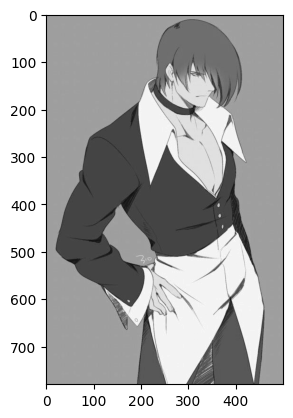

In [26]:
image = cv2.imread("IoriYagami.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")

### 1. Dekomposisi Citra pada Level 3, 4, 5 dan Seterusnya

In [27]:
LPF = np.array([0.7, 0.7])
HPF = np.array([-0.7, 0.7])

Script tersebut menggunakan library NumPy di Python untuk membuat dua array bernama LPF dan HPF. Array LPF memiliki nilai [0.7, 0.7], merepresentasikan koefisien dari filter rendah-pas (LPF), sedangkan array HPF memiliki nilai [-0.7, 0.7], yang merepresentasikan koefisien dari filter tinggi-pas (HPF)

In [28]:
def padding (hasil, n_pad):
    n_pad = len(n_pad)-1
    padd = np.pad (hasil , [0, n_pad], 'constant')
    
    return padd

In [29]:
def filter_1 (matriks, filter, citra):
    konvol1 = np.zeros((citra.shape))
    for i in range (citra.shape[0]):
        for j in range (citra.shape[1]):
            for k in range (len(filter)):
                konvol1[i][j] += (matriks[i, j+k] * filter[k])
    return konvol1

def filter_2 (matriks, filter, citra):
    konvol1 = np.zeros((citra.shape))
    for i in range (citra.shape[0]):
        for j in range (citra.shape[1]):
            for k in range (len(filter)):
                konvol1[i][j] += (matriks[i+k, j] * filter[k])
    return konvol1

In [30]:
def downKol(image):
    if image.shape[1] % 2 == 1:
        image = image[:, :-1] 
    return image[:, ::2]

def downBar(image):
    if image.shape[0] % 2 == 1:
        image = image[:-1, :]
    return image[::2, :]

In [31]:
def dekomposisi(hasil, f1, f2, level):
    if level == 0:
        return hasil
    pad = padding(hasil, f1)
    konvolusi_baris = filter_1(pad, f1, hasil)
    downsampling_baris = downKol(konvolusi_baris)
    pad_kolom = padding(downsampling_baris, f2)
    konvolusi_kolom = filter_2(pad_kolom, f2, downsampling_baris)
    downsampling_kolom = downBar(konvolusi_kolom)
    return dekomposisi(downsampling_kolom, f1, f2, level - 1)

In [32]:
def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized_img = ((img - min_val) / (max_val - min_val)) * 255
    return normalized_img.astype(np.uint8)

In [33]:
def combine_images(images, nrows, ncols):
    row_images = []
    for r in range(nrows):
        row_images.append(np.concatenate(images[r*ncols:(r+1)*ncols], axis=1))
    
    combined_image = np.concatenate(row_images, axis=0)
    return combined_image

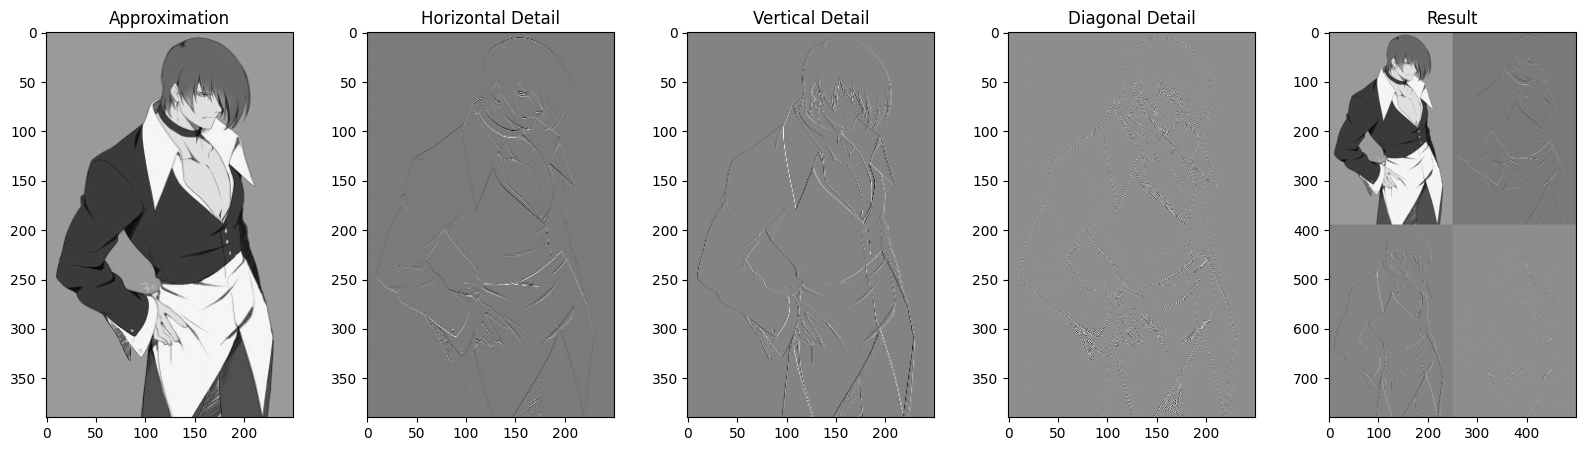

In [34]:
A = dekomposisi(image, LPF, LPF, 1)
H = dekomposisi(image, LPF, HPF, 1)
V = dekomposisi(image, HPF, LPF, 1)
D = dekomposisi(image, HPF, HPF, 1)

# Normalisasi gambar output
A_norm = normalize_image(A)
H_norm = normalize_image(H)
V_norm = normalize_image(V)
D_norm = normalize_image(D)

images = [A_norm, H_norm, V_norm, D_norm]
combined_image = combine_images(images, 2, 2)

# Menampilkan hasil
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs[0].imshow(A, cmap='gray'); axs[0].set_title('Approximation');
axs[1].imshow(H, cmap='gray'); axs[1].set_title('Horizontal Detail');
axs[2].imshow(V, cmap='gray'); axs[2].set_title('Vertical Detail');
axs[3].imshow(D, cmap='gray'); axs[3].set_title('Diagonal Detail');
axs[4].imshow(combined_image, cmap='gray'); axs[4].set_title('Result');
plt.show()

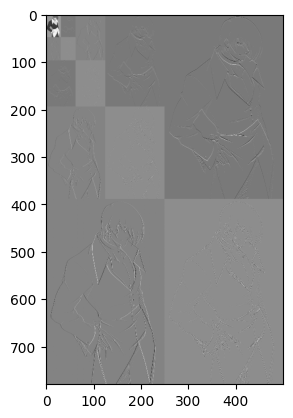

In [37]:

def resize_to_match(image1, image2):
    min_height = min(image1.shape[0], image2.shape[0])
    min_width = min(image1.shape[1], image2.shape[1])
    image1_resized = cv2.resize(image1, (min_width, min_height), interpolation=cv2.INTER_AREA)
    image2_resized = cv2.resize(image2, (min_width, min_height), interpolation=cv2.INTER_AREA)
    return image1_resized, image2_resized

def tampilan(LL, LH, HL, HH):
    LL, HL = resize_to_match(LL, HL)
    LH, HH = resize_to_match(LH, HH)
    baris_1 = np.concatenate((LL, HL), axis=1)
    baris_2 = np.concatenate((LH, HH), axis=1)
    result = np.concatenate((baris_1, baris_2), axis=0)
    return result

def combine_levels(levels):
    combined = levels[0]
    for level in levels[1:]:
        if isinstance(level, list):
            resized_images = [resize_to_match(combined, img)[1] for img in level]
            combined = tampilan(combined, *resized_images)
        else:
            combined, level = resize_to_match(combined, level)
            combined = tampilan(combined, level, level, level) 
    return combined

lvl1 = combined_image  
lvl2 = tampilan(lvl1, H_norm, V_norm, D_norm)
combined_levels_result = combine_levels([lvl2, [V_norm, H_norm, D_norm], [V_norm, H_norm, D_norm]])

plt.imshow(combined_levels_result, cmap='gray')
plt.show()


### 2. Rekonstruksi dari Hasil Dekomposisi

In [36]:
def rekonstruksi(down1, down2, down3, down4):
    tImage, lImage = down1.shape
    t = tImage * 2; l = lImage * 2
    image = np.zeros([t, l])
    LL, LH = np.zeros([t, l]), np.zeros([t, l])
    HL, HH = np.zeros([t, l]), np.zeros([t, l])

    for i in range (t // 2):
        for j in range (l // 2):
            LL[2*i][2*j] = down1[i][j]
            LH[2*i][2*j] = down2[i][j]
            HL[2*i][2*j] = down3[i][j]
            HH[2*i][2*j] = down4[i][j]

    for i in range(1, t, 2):
        for j in range(l):
            LL[i][j] = LL[i-1][j] + LH[i-1][j]
    
    for i in range(t):
        for j in range(1, l, 2):
            LL[i][j] = LL[i][j-1] + HL[i][j-1]
    
    for i in range(t):
        for j in range(l):
            image[i][j] = LL[i][j] + HH[i][j]
    
    return image

reconstructed_images = []
for i in range(num_levels):
    reconstructed_image = rekonstruksi(LL_levels[i], LH_levels[i], HL_levels[i], HH_levels[i])
    reconstructed_images.append(normalize_image(reconstructed_image))

# menampilkan hasil gambar rekonstruksi
fig, axes = plt.subplots(1, num_levels, figsize=(3*num_levels, 10))
for i in range(num_levels):
    axes[i].imshow(reconstructed_images[i], cmap='gray')
    axes[i].set_title(f"Reconstructed Level {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'num_levels' is not defined

### 3. Level berapa hasil dari dekomposisi

Pada gambar tersebut, hasil dekomposisi tersebut merupakan proses dari dekomposisi level 6 keatas. Hal ini dikarenakan dekomposisi merupakan proses untuk memecah gambar menjadi lebih sederhana. Pada gambar tersebut resolusi citra menjadi lebih kecil yang berarti proses dekomposisi citra terjadi pada level yang lebih tinggi yang kemungkinan berada di antara level 6 atau keatasnya seperti yang terlihat pada soal nomor 1 sebelumnya.

In [ ]:
def get_amplitude_index(img):
    amplitude = (img - np.min(img)) * (255 / (np.max(img) - np.min(img)))
    index = np.arange(img.size).reshape(img.shape)

    return amplitude, index

num_levels = 6 

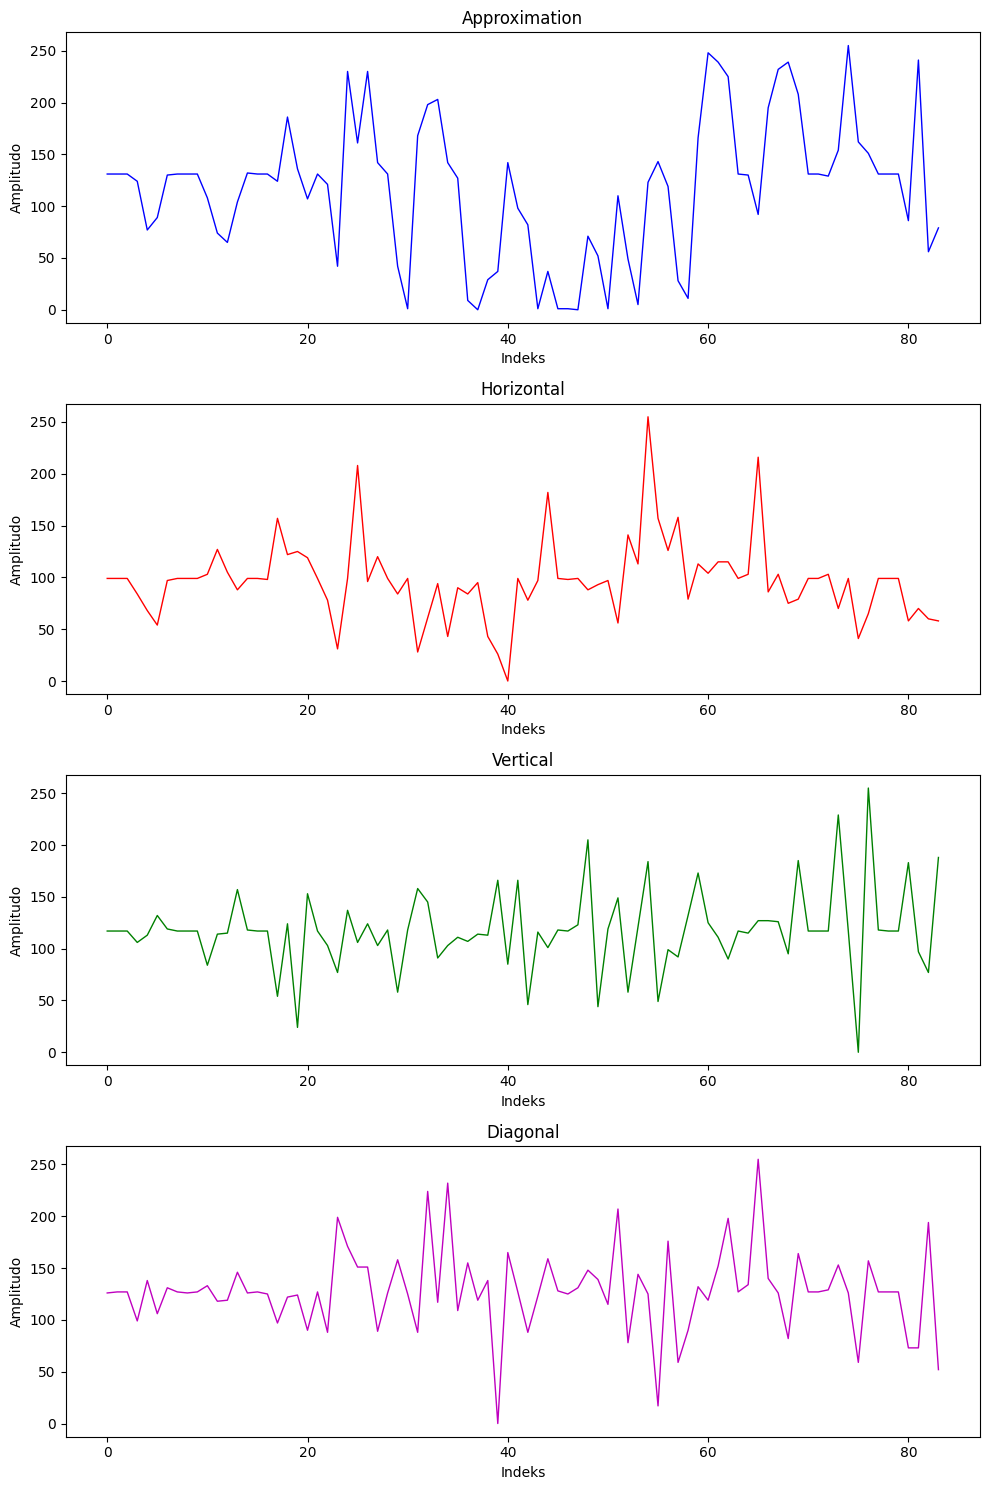

In [ ]:
current_image = image
for level in range(1, num_levels + 1):
    
    LL = dekomposisi(current_image, LPF, LPF)
    LH = dekomposisi(current_image, LPF, HPF)
    HL = dekomposisi(current_image, HPF, LPF)
    HH = dekomposisi(current_image, HPF, HPF)
    
    LL_norm = normalize_image(LL)
    LH_norm = normalize_image(LH)
    HL_norm = normalize_image(HL)
    HH_norm = normalize_image(HH)
    
    if level == 6:
        LL_amp, LL_idx = get_amplitude_index(LL_norm)
        LH_amp, LH_idx = get_amplitude_index(LH_norm)
        HL_amp, HL_idx = get_amplitude_index(HL_norm)
        HH_amp, HH_idx = get_amplitude_index(HH_norm)
        
        fig, axes = plt.subplots(4, 1, figsize=(10, 15))
        
        axes[0].plot(LL_idx.flatten(), LL_amp.flatten(), 'b-', linewidth=1)
        axes[0].set_title("Approximation")
        axes[0].set_xlabel("Indeks")
        axes[0].set_ylabel("Amplitudo")
        
        axes[1].plot(LH_idx.flatten(), LH_amp.flatten(), 'r-', linewidth=1)
        axes[1].set_title("Horizontal")
        axes[1].set_xlabel("Indeks")
        axes[1].set_ylabel("Amplitudo")
        
        axes[2].plot(HL_idx.flatten(), HL_amp.flatten(), 'g-', linewidth=1)
        axes[2].set_title("Vertical")
        axes[2].set_xlabel("Indeks")
        axes[2].set_ylabel("Amplitudo")
        
        axes[3].plot(HH_idx.flatten(), HH_amp.flatten(), 'm-', linewidth=1)
        axes[3].set_title("Diagonal")
        axes[3].set_xlabel("Indeks")
        axes[3].set_ylabel("Amplitudo")
        
        plt.tight_layout()
        plt.show()
    
    current_image = LL 